In [68]:
import numpy as np
from scipy import stats,linalg

import numdifftools as nd

from pathlib import Path

from cobaya.theory import Theory
from cobaya.run import run
from cobaya.log import LoggedError

from getdist.mcsamples import MCSamplesFromCobaya
import getdist.plots as gdplt

In [84]:
rng = np.random.default_rng(1234)
pert_min = 1
pert_max = 2
pert_order = 2 #rng.integers(low=pert_min, high=pert_max, size=1)

coefs_truth = np.zeros(pert_max+1)
coefs_truth[0] = 0.75
coefs_truth[pert_order] = 0.1

poly_truth = np.polynomial.Polynomial(coefs_truth)
sample_std_dev = 0.05

n_samples = 100
sample_points = np.linspace(-1,1,num=n_samples)
samples_truth = poly_truth(sample_points)
sample_noise = rng.normal(0, sample_std_dev, n_samples)
sample_observed = samples_truth+sample_noise

[noisy_data_like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdf's for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {noisy_data_like: 1280.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: q0:0.2679554
[mcmc] Sampling!
[mcmc] Progress @ 2022-03-09 09:52:15 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 40 samples accepted.
[mcmc]  - Acceptance rate: 0.021
[mcmc]  - Convergence of means: R-1 = 0.843694 after 40 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] Learn + convergence test @ 80 s

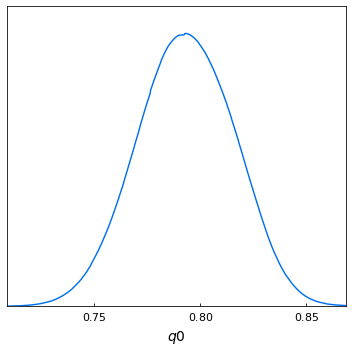

In [85]:
baseline_model_order  =  1
baseline_model_keys =  tuple('q'+str(i) for i in range(baseline_model_order))
baseline_model_ranges = dict((k,(-1,1)) for k in baseline_model_keys)

exec("def get_baseline_polynomial_vals(" + ",".join(baseline_model_keys) + "): return np.polynomial.Polynomial(["+",".join(baseline_model_keys)+"])(sample_points)")

exec("def baseline_noisy_data_logp(" + ",".join(baseline_model_keys) + "): return stats.multivariate_normal.logpdf(get_baseline_polynomial_vals(" + ",".join(baseline_model_keys) + "), mean=sample_observed, cov=sample_std_dev)")

baseline_likelihood_info = {'noisy_data_like': baseline_noisy_data_logp}
baseline_params_info = {k: {"prior": {"min": -1, "max": 1}} for k in baseline_model_keys}
baseline_sampler_info = {'mcmc':{'Rminus1_stop': 0.001, 'max_tries':1000}}
baseline_info = {'likelihood':baseline_likelihood_info,
        'params':baseline_params_info,
        'sampler':baseline_sampler_info}

baseline_updated_info, baseline_sampler = run(baseline_info)
baseline_gdsamples = MCSamplesFromCobaya(baseline_updated_info, baseline_sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(baseline_gdsamples, baseline_model_keys, filled=True)

baseline_bestfit =  baseline_gdsamples.getParamSampleDict(np.argmin(baseline_gdsamples.loglikes))

In [86]:
extnd_model_order  =  pert_max+1
extnd_model_keys =  tuple('q'+str(i) for i in range(extnd_model_order))
extnd_model_csv_keys = ','.join(extnd_model_keys)
extnd_model_ranges = dict((k,(-1,1)) for k in extnd_model_keys)

def get_extnd_polynomial_vals(coefs):
        return np.polynomial.Polynomial(coefs)(sample_points)

def extnd_noisy_data_logp(coefs):
        return stats.multivariate_normal.logpdf(get_extnd_polynomial_vals(coefs), mean=sample_observed, cov=sample_std_dev)

[noisy_data_like] Initialized external likelihood.
[mcmc] Getting initial point... (this may take a few seconds)
[prior] Reference values or pdf's for some parameters were not provided. Sampling from the prior instead for those parameters.
[model] Measuring speeds... (this may take a few seconds)
[model] Setting measured speeds (per sec): {noisy_data_like: 1430.0}
[prior] *WARNING* Reference pdf not defined or improper for some parameters. Using prior's sigma instead for them.
[mcmc] Covariance matrix not present. We will start learning the covariance of the proposal earlier: R-1 = 30 (would be 2 if all params loaded).
[mcmc] Initial point: q0:-0.2120698, q1:0.6120343, q2:0.9690166
[mcmc] Sampling!
[mcmc] Progress @ 2022-03-09 09:52:20 : 1 steps taken, and 0 accepted.
[mcmc] Learn + convergence test @ 120 samples accepted.
[mcmc]  - Acceptance rate: 0.015
[mcmc]  - Convergence of means: R-1 = 0.365408 after 120 accepted steps
[mcmc]  - Updated covariance matrix of proposal pdf.
[mcmc] 

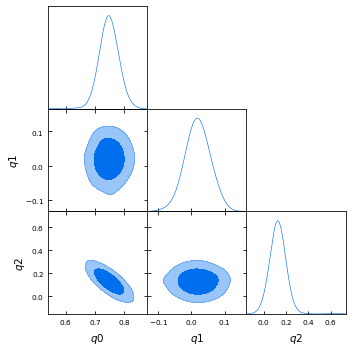

In [87]:

extnd_likelihood_info = {'noisy_data_like': extnd_noisy_data_logp}
extnd_params_info = {k: {"prior": {"min": -1, "max": 1},"drop":True} for k in extnd_model_keys}
extnd_params_info['coefs'] = {'value':"lambda "+','.join(extnd_model_keys)+": ["+','.join(extnd_model_keys)+"]",
                              'derived':False}
extnd_sampler_info = {'mcmc':{'Rminus1_stop': 0.001, 'max_tries':1000}}
extnd_info = {'likelihood': extnd_likelihood_info,
        'params': extnd_params_info,
        'sampler': extnd_sampler_info}

extnd_updated_info, extnd_sampler = run(extnd_info)
extnd_gdsamples = MCSamplesFromCobaya(extnd_updated_info, extnd_sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(extnd_gdsamples, extnd_model_keys, filled=True)

In [88]:
extnd_hess = nd.Hessian(extnd_noisy_data_logp)

extnd_baeline_bestfit = [baseline_bestfit.get(k,0) for k in extnd_model_keys]

In [89]:
F_mu_nu = extnd_hess(extnd_baeline_bestfit)
F_00 = F_mu_nu[0,0]
F_0i = F_mu_nu[0,1:]
F_ij = F_mu_nu[1:,1:]
Sigma_ij = linalg.inv(F_ij)
theta_i = np.einsum('ij,j',Sigma_ij,F_0i)/np.sqrt(np.einsum('i,ij,jk,k',F_0i,Sigma_ij,Sigma_ij,F_0i))

In [90]:
theta_i

array([-2.27000476e-16,  1.00000000e+00])

In [81]:
confusion_model_keys =  ('q0','theta_0')
confusion_model_csv_keys = ','.join(confusion_model_keys)
confusion_model_ranges = dict(zip(confusion_model_keys,((-1,1),(-1/np.max(theta_i),1/np.max(theta_i)))))


def get_confusion_polynomial_vals(coefs):
        return np.polynomial.Polynomial(coefs)(sample_points)

def extnd_noisy_data_logp(coefs):
        return stats.multivariate_normal.logpdf(get_extnd_polynomial_vals(coefs), mean=sample_observed, cov=sample_std_dev)



SyntaxError: invalid syntax (<ipython-input-81-47fe8a82bf36>, line 5)

In [ ]:

def get_extnd_polynomial_vals(coefs):
        return np.polynomial.Polynomial(coefs)(sample_points)

def extnd_noisy_data_logp(coefs):
        return stats.multivariate_normal.logpdf(get_extnd_polynomial_vals(coefs), mean=sample_observed, cov=sample_std_dev)



confusion_likelihood_info = {'noisy_data_like': extnd_noisy_data_logp}
confusion_params_info = {k: {"prior": {"min": -1, "max": 1},"drop":True} for k in extnd_model_keys}
confusion_params_info['coefs'] = {'value':"lambda "+','.join(extnd_model_keys)+": ["+','.join(extnd_model_keys)+"]",
                              'derived':False}
confusion_sampler_info = {'mcmc':{'Rminus1_stop': 0.001, 'max_tries':1000}}
confusion_info = {'likelihood': extnd_likelihood_info,
        'params': extnd_params_info,
        'sampler': extnd_sampler_info}

confusion_updated_info, confusion_sampler = run(confusion_info)
confusion_gdsamples = MCSamplesFromCobaya(confusion_updated_info, confusion_sampler.products()["sample"])
gdplot = gdplt.get_subplot_plotter(width_inch=5)
gdplot.triangle_plot(extnd_gdsamples, extnd_model_keys, filled=True)

In [31]:
np.einsum('ij,j',Sigma_ij,F_0i)/np.sqrt(np.einsum('i,ij,j',F_0i,Sigma_ij,F_0i))

array([1.66234958e-13, 1.28458687e-13])

In [40]:
(np.einsum('ij,j',Sigma_ij,F_0i)/np.sqrt(np.einsum('i,ij,j',F_0i,Sigma_ij,F_0i)))[0]/(np.einsum('ij,j',Sigma_ij,F_0i)/np.sqrt(np.einsum('i,ij,j',F_0i,Sigma_ij,F_0i)))[1]

1.2940733144211634

In [37]:
theta_i[0]/theta_i[1]

1.2940733144211634

In [10]:
extnd_baeline_bestfit = [baseline_bestfit.get(k,0) for k in extnd_model_keys]

In [11]:
extnd_baeline_bestfit

[0.7563653917028231, 0, 0]

In [63]:
np.stack((np.eye(3)[:,0],np.einsum('i,ij',theta_i,np.eye(3)[1:,:])))

array([[1.        , 0.        , 0.        ],
       [0.        , 0.79127487, 0.61146062]])

In [57]:
np.einsum('i,ij',theta_i,np.eye(3)[1:,:])

array([0.        , 0.79127487, 0.61146062])

In [64]:
np.linalg.eig(F_ij)

(array([ 3.48260200e+25, -2.53449929e+24]),
 array([[ 0.99872328, -0.0505154 ],
        [ 0.0505154 ,  0.99872328]]))